In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
#функция, чтоб отобразить последний скриншот
from IPython.display import Image, display
def pic():
  filename = !ls /home/user/Pictures | tail -n 1
  filename = '/home/user/Pictures/' + filename[0] 
  display(Image(filename = filename))

In [389]:
#установка библиотек с помощью конда
#conda install numpy
#conda install pandas
#conda install IPython
#conda install seaborn
#pip install rpy2
#pip install igraph

#И установка BiocManager и edgeR для R 

In [3]:
from IPython.display import Image, display, Markdown
import numpy as np
import pandas as pd
import rpy2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import igraph as ig

In [4]:
#%load_ext autoreload
%load_ext rpy2.ipython
#%autoreload 2

# Check the data

In [5]:
#Загрузим данные всех модальностей
dpath = '/home/user/Uni/SysBio/hw5/'
modalities = ['miRNA', 'mRNA', 'prot']
Datasets = {modality: pd.read_csv(dpath+modality+'.tsv', sep = '\t', index_col = 0) for modality in modalities} 

In [6]:
#Изучим что в данных
for modality in modalities: 
    display(Datasets[modality].head(3).iloc[:,0:4])

,A0FJ,A13E,A0G0,A0SX
miRNA,,,,
hsa-let-7a-1,11.835816,12.897932,12.307726,12.039293
hsa-let-7a-2,12.851047,13.900869,13.290325,13.010807
hsa-let-7a-3,11.918811,12.912726,12.300625,12.081407


,A0FJ,A13E,A0G0,A0SX
Gene,,,,
RTN2,4.362183,1.984492,1.727323,4.363996
NDRG2,7.533461,7.455194,8.079968,5.793750
CCDC113,3.956124,5.427623,2.227300,3.544866


,A0FJ,A13E,A0G0,A0SX
Protein,,,,
14-3-3_epsilon,0.059131,-0.079982,-0.032850,-0.205329
4E-BP1,0.447486,0.605218,0.894610,-0.141323
4E-BP1_pS65,-0.074322,0.288912,0.891278,-0.018411


In [394]:
#Размер данных
{modality: Datasets[modality].shape for modality in modalities}

{'miRNA': (184, 150), 'mRNA': (200, 150), 'prot': (142, 150)}

Итого всего 150 'образцов', для каждого из них 184 + 200 + 142 признаков из результатов 3 разных экспериментов.
Сначала попробую проанилизировать их по отдельности.

# Clustering each dataset separately (With Leiden)

In [404]:
#Для начала задам матрицы расстояний как 1-coor
import igraph as ig
import leidenalg as la
cDatasets = {modality: tDatasets[modality].corr() for modality in modalities}#correlation matrices
dDatasets = {modality: 1-tDatasets[modality].corr() for modality in modalities} #distances matrices

Для получения кластеров используем кластеризацию Leiden на графах. <br>
https://www.nature.com/articles/s41598-019-41695-z <br>
Графы получим путём соединения тех образцов друг с другом, у которых корреляция выше какого-то порога. Напишу функцию, которая превращает матрицу корреляций в adjacency matrix на основании какого-то порога. (Корреляция больше порога- edge есть, меньше - edge отсутствует)

<AxesSubplot:>

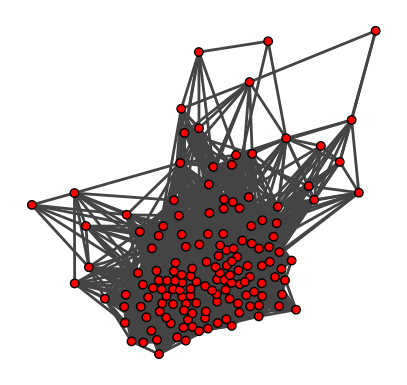

Получился нечитаемый граф. Но далее увеличим размер изображения и найдём communities с помощью Leiden

<AxesSubplot:>

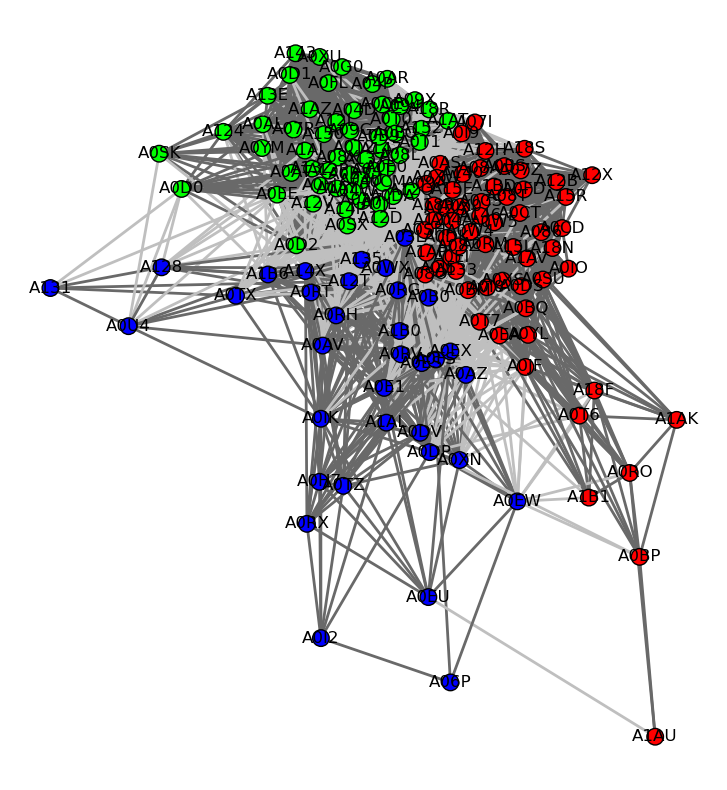

<AxesSubplot:>

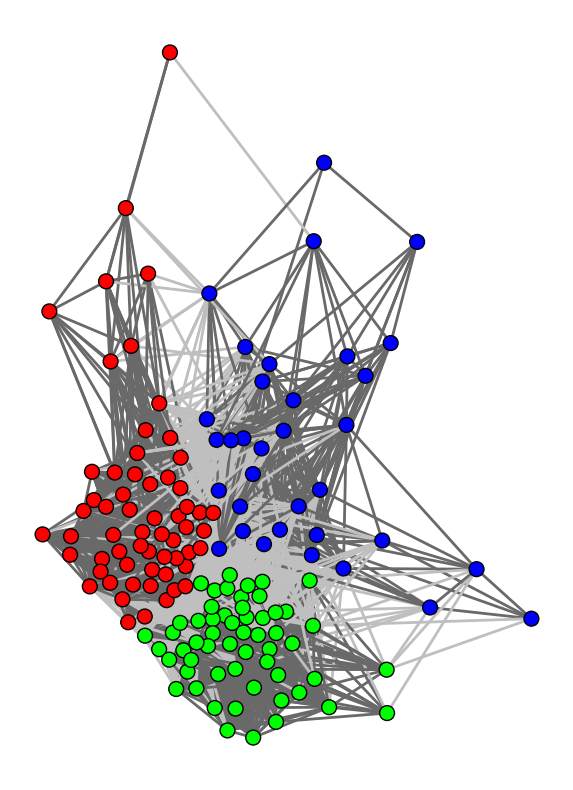

In [411]:
#Итоговые классы можно получить через:
partition._membership[0:9]

[1, 1, 1, 1, 1, 1, 1, 2, 2]

In [412]:
#Посчитаем метрику для качества кластеризации
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
#Для этого используем нормализованный датасет
davies_bouldin_score(tDatasets['prot'].T, partition._membership)

2.303829711522365

Чем меньше больше silhoutte score и calinski score, тем лучше (Но тем больше точек окажутся в отдельных кластерах)
Ради интереса я считаю метрики для разных порогов. Для каждой из модальностей я подобрал с помощью следующей ячейки свой порог. Ниже пример для протеинов, для которых я выбрал порог 0.45

При пороге 0.3, 	 bouldin score: 2.3201100846890697, 	 silhoutte score: 0.1071379776582341, 		 calinski score: 17.96226976843835
При пороге 0.35, 	 bouldin score: 2.3444225731520167, 	 silhoutte score: 0.10615975581749258, 		 calinski score: 16.615107922562487
При пороге 0.4, 	 bouldin score: 2.285277900317764, 	 silhoutte score: 0.11288068309366285, 		 calinski score: 18.784883453521562
При пороге 0.45, 	 bouldin score: 2.2869011279911073, 	 silhoutte score: 0.10757134808536596, 		 calinski score: 18.94213664693327
При пороге 0.5, 	 bouldin score: 1.933329088754653, 	 silhoutte score: 0.09391782518336661, 		 calinski score: 13.0744588003643
При пороге 0.55, 	 bouldin score: 1.6115952841516161, 	 silhoutte score: 0.03923307691541399, 		 calinski score: 8.428631511201505
При пороге 0.6, 	 bouldin score: 1.5208858230159985, 	 silhoutte score: 0.006927412740934916, 		 calinski score: 6.1085584400941855
При пороге 0.65, 	 bouldin score: 1.0845413943665339, 	 silhoutte score: -0.00093092011

Теперь определим кластера для каждого из датасетов и запишем их в датафрейм

В итоге для каждой из модальностей получились вот такие кластера

In [415]:
df_clusters

,miRNA,mRNA,prot
A0FJ,1,0,0
A13E,1,0,0
A0G0,1,0,0
A0SX,2,0,0
A143,1,0,0
...,...,...,...
A0BS,3,2,1
A08O,0,2,1
A12H,3,2,1
A15E,0,2,1


In [416]:
df_clusters.value_counts()

miRNA  mRNA  prot
1      0     0       32
0      1     2       14
3      2     1       14
0      2     1       11
2      0     0       10
0      2     2        9
4      2     1        7
2      1     0        7
4      1     1        7
0      1     1        5
2      0     2        5
0      1     0        4
2      1     2        3
       2     1        3
4      2     2        3
3      1     0        2
             1        2
             2        2
4      1     2        2
1      0     2        2
3      2     0        1
0      0     2        1
3      2     2        1
4      0     2        1
2      1     1        1
0      0     0        1
dtype: int64

Как видно, взаимоотношение между различными кластеризациями непростое. Имеется много сочетаний, для которых имеется всего 1-3 образцы, и ни в одном случае нельзя сделать 1 на 1 соответствие между кластерами

# Naïve early integration of data. Leiden

Снова используем Leiden, но на этот раз просто сразу объединим датасеты и посмотрим, что получится

In [418]:
t_all

,A0FJ,A13E,A0G0,A0SX,A143,A0DA,A0B3,A0I2,A0RT,A131,...,A03L,A1AK,A0E1,A0H7,A0FS,A0BS,A08O,A12H,A15E,A0W4
hsa-let-7a-1,0.237665,0.540689,0.372302,0.295718,0.681354,0.381616,0.409383,0.435158,0.378765,0.475608,...,0.268758,0.650186,0.802332,0.525949,0.677719,0.732626,0.610994,0.778620,0.631042,0.323270
hsa-let-7a-2,0.234771,0.536468,0.361011,0.280683,0.676981,0.380994,0.394221,0.426620,0.346396,0.465698,...,0.263789,0.642195,0.795413,0.516951,0.666052,0.727875,0.606832,0.776070,0.626625,0.315802
hsa-let-7a-3,0.251323,0.539004,0.361836,0.298385,0.686489,0.388631,0.409262,0.431653,0.359383,0.472457,...,0.286330,0.645815,0.797387,0.533297,0.674569,0.730928,0.613207,0.780411,0.630277,0.328772
hsa-let-7b,0.410431,0.394309,0.460150,0.376382,0.505100,0.420884,0.591648,0.480592,0.449944,0.399543,...,0.538046,0.360276,1.000000,0.574246,0.581554,0.418666,0.762513,0.666764,0.325461,0.381418
hsa-let-7c,0.550452,0.752139,0.550131,0.649046,0.405323,0.630463,0.573102,0.791827,0.678423,0.593225,...,0.628318,0.698097,0.650736,0.711103,0.737654,0.574125,0.696677,0.219337,0.691864,0.602382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p38_pT180_Y182,0.298834,0.373841,0.374988,0.585308,0.595635,0.491196,0.704331,0.628348,0.617187,0.560662,...,0.522143,0.672491,0.775323,0.373579,0.770922,0.322556,0.676490,0.708414,0.464820,0.780501
p53,0.617641,0.679231,0.549133,0.700111,0.567052,0.678637,0.711404,0.578685,0.640285,0.707367,...,0.612164,0.299336,0.634517,0.651896,0.532278,0.602725,0.588200,0.545521,0.606783,0.529440
p70S6K,0.199560,0.239880,0.190661,0.215782,0.313421,0.227500,0.239848,0.047463,0.149937,0.128697,...,0.254491,0.322520,0.145517,0.048563,0.164427,0.242629,0.158437,0.243760,0.171524,0.235481
p70S6K_pT389,0.182435,0.392213,0.189025,0.185479,0.109164,0.264952,0.342801,1.000000,0.486175,0.297329,...,0.220413,0.209686,0.183022,0.376805,0.194163,0.201506,0.497128,0.177279,0.128735,0.163359


<AxesSubplot:>

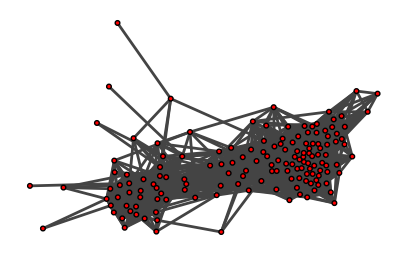

Получился нечитаемый граф. Но далее увеличим размер изображения и найдём communities с помощью Leiden

<AxesSubplot:>

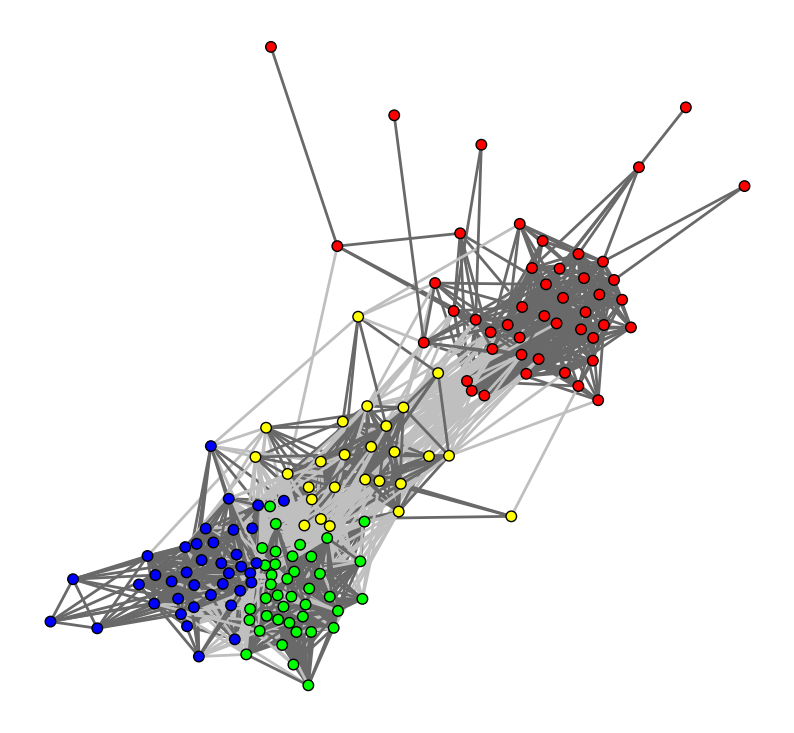

Получилось 4 кластера. Добавим полученную кластеризацию образцов в датафрейм с кластеризациями

,miRNA,mRNA,prot,naive_leiden
A0FJ,1,0,0,0
A13E,1,0,0,0
A0G0,1,0,0,0
A0SX,2,0,0,0
A143,1,0,0,0
...,...,...,...,...
A0BS,3,2,1,2
A08O,0,2,1,2
A12H,3,2,1,2
A15E,0,2,1,2


# Late integration. Cluster of clusters analysis for Leiden

Поскольку уже были получены кластеризации для отдельных модальностей, можно объединить данные, получим кластера 2-ого порядка (COCA = Cluster of clusters analysis)
С этим анализом сталкнулся в следующей статье: https://www.cell.com/cell/fulltext/S0092-8674(14)00876-9?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867414008769%3Fshowall%3Dtrue

In addition to the COCA classification, we used two additional, independent methods to derive Pan-Cancer-12 subtypes based on integrated data: (1) an algorithm called SuperCluster (Kandoth et al., 2013b) (Figure S2B) and (2) clustering based on inferred pathway activities from PARADIGM (Vaske et al., 2010), which integrates gene expression and DNA copy-number data with a set of predefined pathways to infer the degree of activity of 17,365 pathway features such as proteins, complexes, and cellular processes (Figure S2C).

Описание пакета:
https://cran.r-project.org/web/packages/coca/vignettes/coca-vignette.html

In [423]:
#install.packages("coca")
%R library(coca)

'iCluster...,'parallel','coca',...,'datasets','methods','base'


In [427]:
bclusters #binarized matrix of clusters

,miRNA_0,miRNA_1,miRNA_2,miRNA_3,miRNA_4,mRNA_0,mRNA_1,mRNA_2,prot_0,prot_1,prot_2
A0FJ,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
A13E,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
A0G0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
A0SX,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
A143,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
A0BS,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
A08O,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
A12H,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
A15E,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [429]:
%R -i moc

Посмотрим на то, как разные кластеризации соотносятся друг с другом

/home/user/miniconda3/envs/NGSenv/lib/python3.10/site-packages/rpy2/ipython/rmagic.py:883: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(data=disp_d, source=tag,


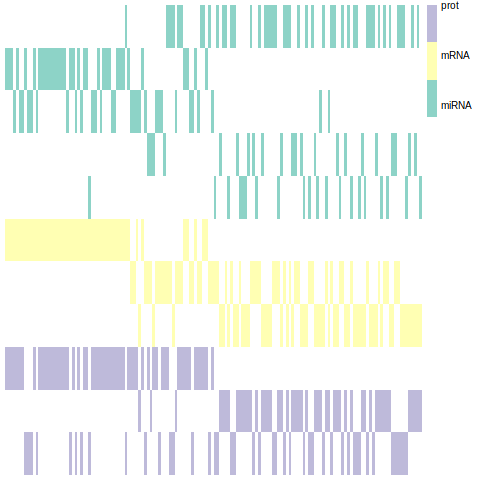

In [430]:
%%R
coca::plotMOC(moc, c(1,1,1,1,1,2,2,2,3,3,3), datasetNames = c('miRNA', 'mRNA', 'prot'))

Из-за отсутствия сортировки выглядит немного некрасиво, поэтому подадим отсортированный датафрейм

/home/user/miniconda3/envs/NGSenv/lib/python3.10/site-packages/rpy2/ipython/rmagic.py:883: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(data=disp_d, source=tag,


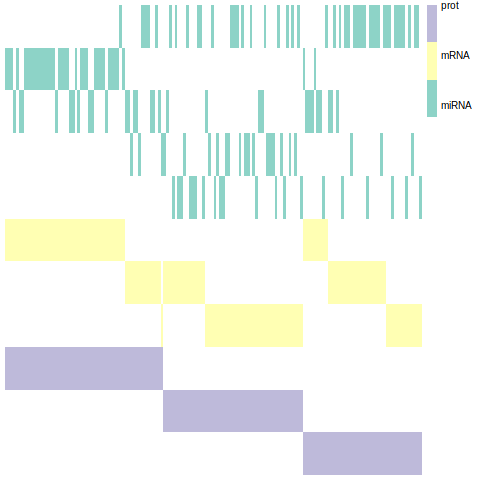

In [432]:
%%R
coca::plotMOC(moc_sorted, c(1,1,1,1,1,2,2,2,3,3,3), datasetNames = c('miRNA', 'mRNA', 'prot'))

Отсюда уже видно соотношение классов из разных кластеризаций. Например, нулевой класс miRNA никогда не соотвестствует первому классу протеинов.

Теперь Cluster of clusters analysis

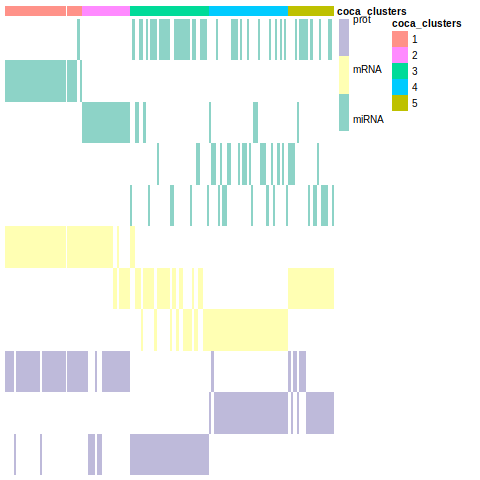

In [433]:
%%R
coca = coca::coca(moc, K = 5)
annotations = data.frame(coca_clusters = as.factor(coca$clusterLabels))
rownames(annotations) = rownames(moc)
coca::plotMOC(moc[order(annotations),], c(1,1,1,1,1,2,2,2,3,3,3), datasetNames = c('miRNA', 'mRNA', 'prot'), annotations = annotations)

Мне больше всего понравился вариант с 5 кластерами, так как начиная с 5 класс miRNA начинает играть важную роль

In [ ]:
#Добавим аннотацию COCA в датафрейм

In [435]:
df_clusters['coca_leiden'] = coca_leiden
df_clusters

,miRNA,mRNA,prot,naive_leiden,coca_leiden
A0FJ,1,0,0,0,1
A13E,1,0,0,0,1
A0G0,1,0,0,0,1
A0SX,2,0,0,0,2
A143,1,0,0,0,1
...,...,...,...,...,...
A0BS,3,2,1,2,4
A08O,0,2,1,2,4
A12H,3,2,1,2,4
A15E,0,2,1,2,4


# Simultaneous analysis. ICluster

In [436]:
#BiocManager::install("iClusterPlus")
#https://www.bioconductor.org/packages/release/bioc/vignettes/iClusterPlus/inst/doc/iManual.pdf

In [437]:
rDatasets = list(Datasets.copy().values())
rDatasets0 = rDatasets[0].T
rDatasets1 = rDatasets[1].T
rDatasets2 = rDatasets[2].T
%R -i rDatasets0
%R -i rDatasets1
%R -i rDatasets2

In [438]:
%%R
library(iClusterPlus)
fit = iClusterPlus(dt1=as.matrix(rDatasets0),dt2=as.matrix(rDatasets1), dt3=as.matrix(rDatasets2), K=3, lambda=c(0.2,0.2,0.2), maxiter=50, type=c("gaussian", "gaussian", "gaussian"), sdev=0.05,eps=1.0e-4)

In [439]:
#Полученные кластера
%R fit$clusters

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2,
       2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 4,
       1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 3, 4, 3, 3, 4, 3, 1, 4, 3, 3, 1, 4,
       3, 1, 3, 3, 1, 3, 1, 4, 1, 1, 3, 4, 1, 1, 1, 3, 3, 3, 4, 3, 3, 3,
       1, 4, 3, 1, 3, 1, 1, 3, 4, 1, 3, 3, 1, 4, 1, 3, 3, 3, 4, 3, 1, 3,
       4, 4, 3, 4, 3, 1, 4, 4, 1, 1, 3, 3, 3, 4, 3, 4, 3, 3], dtype=int32)

In [51]:
%R fit.single$BIC #Метрика, по которой можно подбирать кластеризацию

array([38507.31576521])

In [440]:
#Запишем полученные кластера в таблицу
%R iCluster_output = fit$clusters
%R -o iCluster_output
df_clusters['iCluster'] = iCluster_output
df_clusters

,miRNA,mRNA,prot,naive_leiden,coca_leiden,iCluster
A0FJ,1,0,0,0,1,2
A13E,1,0,0,0,1,2
A0G0,1,0,0,0,1,2
A0SX,2,0,0,0,2,2
A143,1,0,0,0,1,2
...,...,...,...,...,...,...
A0BS,3,2,1,2,4,4
A08O,0,2,1,2,4,3
A12H,3,2,1,2,4,4
A15E,0,2,1,2,4,3


In [441]:
df_clusters[['naive_leiden', 'coca_leiden', 'iCluster']].value_counts()

naive_leiden  coca_leiden  iCluster
0             1            2           31
2             4            4           15
1             3            3           14
                           1           13
0             2            2           11
2             4            3           10
3             2            1            9
1             5            3            7
3             5            1            7
2             4            1            6
1             4            1            3
2             5            1            3
3             3            1            3
              5            3            2
2             3            4            2
0             1            4            2
              3            1            1
              2            1            1
3             4            1            1
              3            3            1
              2            2            1
1             5            1            1
3             1            2            

Результаты разбиения во многом похожи. Но второй по величине кластер, полученный с помощью Leiden, iCluster разбил на 2 части. 

Сохраним в файл 

In [443]:
results = df_clusters[['naive_leiden', 'coca_leiden', 'iCluster']].astype('str')
results = 'cl' + results
results

,naive_leiden,coca_leiden,iCluster
A0FJ,cl0,cl1,cl2
A13E,cl0,cl1,cl2
A0G0,cl0,cl1,cl2
A0SX,cl0,cl2,cl2
A143,cl0,cl1,cl2
...,...,...,...
A0BS,cl2,cl4,cl4
A08O,cl2,cl4,cl3
A12H,cl2,cl4,cl4
A15E,cl2,cl4,cl3


In [444]:
results.to_csv('/home/user/Uni/SysBio/results.tsv', sep = '\t')

Done.